### Hyperparameters

In [1]:
#### Exploratory Analysis
Analysis = True

#### Column Removal
Remove_Cols_with_many_bad_data = True
NaN_Zero_Threshold = 0.8

#### Outliers
RemoveOutliers = False    #Using IQR
Times_IQR = 1.5           #Normal factor (1.5). Kills minority class if class included!!

## Outliers by class
RemoveOutliers_PositiveClass = False
RemoveOutliers_NegativeClass = False  #It removes >90% of the class

#### NaN and Zero replacement
NaN_Zero_Replacement = True
NaN_Zero_Replacement_Mode = 'general' #general or perClass
NaN_Zero_Replacement_Operation = 'median' #median or mean
NaN_Zero_Replacement_Sort = True

#### Data Projections
ProjectBins = True
ProjectBin_Operation = "mean"  #sum or mean
RemoveSubBins = True

#### Rounding values
Rounding = False     #Does not change the results and makes the process faster
RoudingDecimals = 2

#### Feature Selection
RunCorrelationAnalysis = True   #Using Pearson Correlation
Corr_FeatureSelection = 2   #0, 1, 2, 3, 4

#### Resampling
Upsampling = True                #Previous to Bagging
UpsamplingAproach = 'ADASYN'    #ADASYN/SMOTE
_sampling_strategy = 0.8                #'minority'/double

#### Train-Test split
EnableSplitting = True    #If False, no RF score and CM can be calculated
_test_size = 0.2

#### GridSearch
GridSearch = False
_cv = 5
_verbose = 3
## RF
ParamGrid_RF = {'max_depth': [4,5,6,10,20], 'n_estimators':[100], \
                'class_weight':[{0:1,1:35},{1:35,0:1},'balanced'], \
                'verbose':[1], 'bootstrap': [True]};    # 'class_weight':[{0:1,1:35},{1:35,0:1}]
## SVM
SVM_Kernels = ['rbf','linear']    #['linear', 'rbf','sigmoid','poly']
SVM_Cs = [0.1, 1, 10]
SVM_gammas = [0.1, 1]
ParamGrid_SVM = {'kernel': SVM_Kernels, 'C': SVM_Cs, 'gamma': SVM_gammas, 'verbose':[2]}

#### Model to Use
Multimode = False   # Not implemented
ModelToUse = 'RF'  # RF,SVM

#### Random Forest Parameters (ONLY WHEN GRIDSEARCH False)
_max_depth = 5        #None (default)
_n_estimators = 100
_bootstrap = True
_class_weight ='balanced'
_SEED = 1
_n_jobs = -1

#### Support Vector Machine (ONLY WHEN GRIDSEARCH False)
_C=10.0
_kernel='sigmoid'       #'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
_degree=3               #3(default)
_gamma='scale'
_coef0=0.0
_shrinking=True
_probability=True
_tol=0.001
_cache_size=200
_class_weight=None
_verbose=True
_max_iter=-1
_decision_function_shape='ovr'
_random_state=None

#### Bagging
Bagging = True
# BC
_n_bootstraps = 3
_n_estimators = 10
_max_samples = 1.0
_max_features = 1.0
_bootstrap = True
_bootstrap_features = False
_bootstrap = True
_bootstrap_features = False
_oob_score = False
_warm_start = False
_n_jobs = 4
_random_state = None
_verbose = 3

#### Favor True Class (after prediction), not needed if SearchGreed (with scorer) True
FavorTrueClass = False
FavorThreshold = 0.45    #All False predictions between [0.5,FavorThreshold) are switched to True

SaveToFile = True
FileName = "prediction_results_v6.csv"

#### Use existing model
UseExistingModel = False
modelFileName = "model_v6_MAC.joblib"
if (UseExistingModel == True):
    print("Using model from disk!!!!!!")

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
#import winsound

from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

### Usefull functions

In [3]:
def ColumnFiltering1_ZerosNaNs_byThreshold(data,threshold):
    
    columnsNames = list(data.columns.values)
    total_rows = train.shape[0]
    thr = total_rows * threshold
    
    for i in columnsNames:
        count = 0
        
        s = data[i]
        if (i!= 'class'):
            for j in s:
                if math.isnan(j) or j == 0.0:
                    count += 1
            #print(i + " " + str(count))
        if count >= thr:
            data.drop(i, axis = 1, inplace = True)
            #print ("Droping " + i)
            
def ClassTo01(data):
    data["class"].replace(to_replace = "neg", value = "0", inplace = True)
    data["class"].replace(to_replace = "pos", value = "1", inplace = True)
    
def PositiveData(data):
    return data[(data["class"] == 1)]
    
def NegativeData(data):
    return data[(data["class"] == 0)]

def ReplaceNaNsForStats(data,strategy):
    columnsNames = list(data.columns.values)
    imp = Imputer(missing_values = "NaN", strategy = strategy, axis = 0, copy = False)
    d = imp.fit_transform(data)
    aux = pd.DataFrame(d, columns=columnsNames)
    aux.index = data.index
    return aux.copy()

def NewColFromBin_v2(data,colName,op):
    sum = 0
    
    if colName + '_000' in data.columns: sum += data[colName + '_000']
    if colName + '_001' in data.columns: sum += data[colName + '_001']
    if colName + '_002' in data.columns: sum += data[colName + '_002']
    if colName + '_003' in data.columns: sum += data[colName + '_003']
    if colName + '_004' in data.columns: sum += data[colName + '_004']
    if colName + '_005' in data.columns: sum += data[colName + '_005']
    if colName + '_006' in data.columns: sum += data[colName + '_006']
    if colName + '_007' in data.columns: sum += data[colName + '_007']
    if colName + '_008' in data.columns: sum += data[colName + '_008']
    if colName + '_009' in data.columns: sum += data[colName + '_009']
    
    if (op == 'sum'): retorno = sum
    if (op == 'mean'): retorno = sum/10

    return retorno
    
def DropBins(data,binName):
    if binName + '_000' in data.columns: data.drop(binName + '_000', axis = 1, inplace = True)
    if binName + '_001' in data.columns: data.drop(binName + '_001', axis = 1, inplace = True)
    if binName + '_002' in data.columns: data.drop(binName + '_002', axis = 1, inplace = True)
    if binName + '_003' in data.columns: data.drop(binName + '_003', axis = 1, inplace = True)
    if binName + '_004' in data.columns: data.drop(binName + '_004', axis = 1, inplace = True)
    if binName + '_005' in data.columns: data.drop(binName + '_005', axis = 1, inplace = True)
    if binName + '_006' in data.columns: data.drop(binName + '_006', axis = 1, inplace = True)
    if binName + '_007' in data.columns: data.drop(binName + '_007', axis = 1, inplace = True)
    if binName + '_008' in data.columns: data.drop(binName + '_008', axis = 1, inplace = True)
    if binName + '_009' in data.columns: data.drop(binName + '_009', axis = 1, inplace = True)

def FavorTrues(p):
    if (p > FavorThreshold):
        retorno = 'true'
    else:
        retorno = 'false'
    return retorno

def getCost(y_test,y_pred):
    tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()
    return (fp*100 + fn*3500)


def Beep():
    frequency = 2500  # Set Frequency To 2500 Hertz
    duration = 1000  # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)

### Loading datasets

In [4]:
#Loading Training and Test datasets
train = pd.read_csv("aps_failure_train.csv", na_values="na")
test = pd.read_csv("aps_failure_test.csv", na_values="na")
#test = pd.read_csv("aps_failure_test_set.csv", na_values="na")

### Data Discovery


In [5]:
#Checking class feature
train["class"].value_counts()

False    55968
True      1032
Name: class, dtype: int64

In [6]:
#Data types
if(Analysis == True):
    print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57000 entries, 0 to 56999
Columns: 171 entries, class to eg_000
dtypes: bool(1), float64(169), int64(1)
memory usage: 74.0 MB
None


In [7]:
#Statistics
if(Analysis == True):
    stats = train.describe()
    print(stats.round().T)

          count         mean          std  min      25%        50%        75%  \
aa_000  57000.0      61074.0     232734.0  0.0    872.0    30840.0    48942.0   
ab_000  13046.0          1.0          3.0  0.0      0.0        0.0        0.0   
ac_000  53781.0  354187065.0  793240902.0  0.0     16.0      152.0      966.0   
ad_000  42725.0     201369.0   41530171.0  0.0     24.0      128.0      432.0   
ae_000  54609.0          7.0        144.0  0.0      0.0        0.0        0.0   
af_000  54609.0         11.0        196.0  0.0      0.0        0.0        0.0   
ag_000  56328.0        224.0      20940.0  0.0      0.0        0.0        0.0   
ag_001  56328.0       1106.0      35294.0  0.0      0.0        0.0        0.0   
ag_002  56328.0       9526.0     161482.0  0.0      0.0        0.0        0.0   
ag_003  56328.0      92700.0     759330.0  0.0      0.0        0.0        0.0   
ag_004  56328.0     445606.0    2217632.0  0.0    310.0     3706.0    50974.0   
ag_005  56328.0    1124752.0

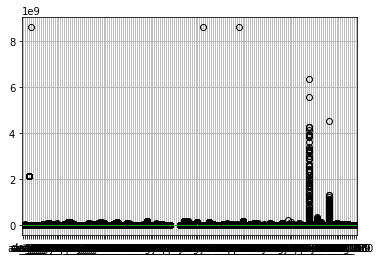

In [8]:
#Outliers
if(Analysis == True):
    boxplot = train.boxplot()
#train.columns.values

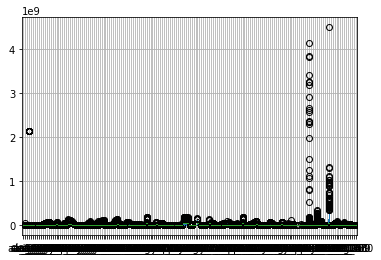

In [9]:
if(Analysis == True):
    positiveData = PositiveData(train)
    negativeData = NegativeData(train)
    boxplot = positiveData.boxplot()

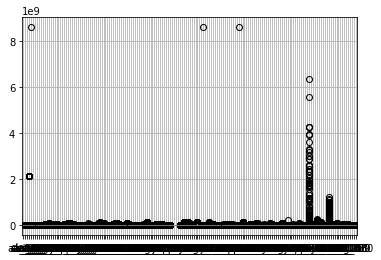

In [10]:
if(Analysis == True):
    boxplot = negativeData.boxplot()

### Cleansing, data preparation, correlation analysis, feature selection, proyections, resampling..


In [11]:
#test = test.drop('class', axis=1)
test['class'] = False

ClassTo01(train)
train["class"] = pd.to_numeric(train["class"])
#ClassTo01(test)
#test["class"] = pd.to_numeric(test["class"])
#train.iloc[7:12,0]

In [12]:
if (RemoveOutliers == True): #Carefull, it kills minority class if class included!!
    print("RemoveOutliers On")
    Q1 = train.quantile(0.25)
    Q3 = train.quantile(0.75)
    IQR = Q3 - Q1
    
    rows = train['class'].count()
    
    train = train[~((train.loc[:, train.columns != 'class'] < (Q1 - Times_IQR * IQR))\
                    |(train.loc[:, train.columns != 'class'] > (Q3 + Times_IQR * IQR))).any(axis=1)]
    rows_NoOutliers = train['class'].count()
    
    print(str(rows) + "-" + str(rows_NoOutliers) + " = " + str(rows-rows_NoOutliers))
    train["class"].value_counts()
else:   
    if (RemoveOutliers_PositiveClass == True or RemoveOutliers_NegativeClass == True):

        rows = train['class'].count()
        positiveData = PositiveData(train)
        negativeData = NegativeData(train)

        if (RemoveOutliers_PositiveClass == True):
            print("RemoveOutliers_PositiveClass On")
            
            Q1 = positiveData.quantile(0.25)
            Q3 = positiveData.quantile(0.75)
            IQR = Q3 - Q1
            positiveData = positiveData[~((positiveData < (Q1 - Times_IQR * IQR)) |(positiveData > (Q3 + Times_IQR * IQR))).any(axis=1)]

        if (RemoveOutliers_NegativeClass == True):
            print("RemoveOutliers_NegativeClass On")
            
            Q1 = negativeData.quantile(0.25)
            Q3 = negativeData.quantile(0.75)
            IQR = Q3 - Q1
            negativeData = negativeData[~((negativeData < (Q1 - Times_IQR * IQR)) |(negativeData > (Q3 + Times_IQR * IQR))).any(axis=1)]

        train = pd.concat([positiveData,negativeData])
        train.sort_index(inplace=True)

        rows_WithoutOutliers = train['class'].count()

        print(str(rows) + "-" + str(rows_WithoutOutliers) + " = " + str(rows-rows_WithoutOutliers))
print (train["class"].value_counts())

False    55968
True      1032
Name: class, dtype: int64


In [13]:
if (Remove_Cols_with_many_bad_data == True):
    print (train.shape)
    print (test.shape)
    print("Remove_Cols_with_many_bad_data On")
    ColumnFiltering1_ZerosNaNs_byThreshold(train,NaN_Zero_Threshold)
    test = test[train.columns.values]

print (train.shape)
print (test.shape)

(57000, 171)
(19000, 171)
Remove_Cols_with_many_bad_data On
(57000, 129)
(19000, 129)


In [14]:
if (NaN_Zero_Replacement):
    if (NaN_Zero_Replacement_Mode == 'general'):
        print("NaN_Zero_Replacement_Mode-General On")
        
        train = ReplaceNaNsForStats(train,NaN_Zero_Replacement_Operation)
        test = ReplaceNaNsForStats(test,NaN_Zero_Replacement_Operation)
        
    else: 
        if(NaN_Zero_Replacement_Mode == 'perClass'):
            print("NaN_Zero_Replacement_Mode-PerClass On")
            
            positiveData = PositiveData(train)
            negativeData = NegativeData(train)
            Data_P = ReplaceNaNsForStats(positiveData,NaN_Zero_Replacement_Operation)
            Data_N = ReplaceNaNsForStats(negativeData,NaN_Zero_Replacement_Operation)
            train = pd.concat([Data_P,Data_N])
            if (NaN_Zero_Replacement_Sort == True): 
                train.sort_values('aa_000', axis=0, ascending=True, inplace=True)
            test = ReplaceNaNsForStats(test,NaN_Zero_Replacement_Operation)


train.shape

NaN_Zero_Replacement_Mode-General On


//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


(57000, 129)

In [15]:
if (ProjectBins == True):
    print("ProjectBins On")
    #### Projecting bins into 7 new Features that summarize/average the bin's values.
    train['ag'] = NewColFromBin_v2(train,'ag', ProjectBin_Operation)
    train['ay'] = NewColFromBin_v2(train,'ay', ProjectBin_Operation)
    train['az'] = NewColFromBin_v2(train,'az', ProjectBin_Operation)
    train['ba'] = NewColFromBin_v2(train,'ba', ProjectBin_Operation)
    train['cn'] = NewColFromBin_v2(train,'cn', ProjectBin_Operation)
    train['cs'] = NewColFromBin_v2(train,'cs', ProjectBin_Operation)
    train['ee'] = NewColFromBin_v2(train,'ee', ProjectBin_Operation)

    test['ag'] = NewColFromBin_v2(test,'ag', ProjectBin_Operation)
    test['ay'] = NewColFromBin_v2(test,'ay', ProjectBin_Operation)
    test['az'] = NewColFromBin_v2(test,'az', ProjectBin_Operation)
    test['ba'] = NewColFromBin_v2(test,'ba', ProjectBin_Operation)
    test['cn'] = NewColFromBin_v2(test,'cn', ProjectBin_Operation)
    test['cs'] = NewColFromBin_v2(test,'cs', ProjectBin_Operation)
    test['ee'] = NewColFromBin_v2(test,'ee', ProjectBin_Operation)

    
if (RemoveSubBins == True):
    print("RemoveSubBins On")
    # We are loosing the variance of the bins
    # but we are simplifying the model by reducing the features
    
    # Removing splitted bins
    DropBins(train,'ag')
    DropBins(train,'ay')
    DropBins(train,'az')
    DropBins(train,'ba')
    DropBins(train,'cn')
    DropBins(train,'cs')
    DropBins(train,'ee')
    
    DropBins(test,'ag')
    DropBins(test,'ay')
    DropBins(test,'az')
    DropBins(test,'ba')
    DropBins(test,'cn')
    DropBins(test,'cs')
    DropBins(test,'ee')

ProjectBins On
RemoveSubBins On


In [16]:
if (Rounding == True):
    print("Rounding On")
    train.round(RoudingDecimals)
    test.round(RoudingDecimals)

In [17]:
cor = 0
if (RunCorrelationAnalysis == True):
    #print("RunCorrelationAnalysis On")
    #### Filter Method for Feature Correlation with Class Feature
    #Using Pearson Correlation
    #plt.figure(figsize=(12,10))
    cor = train.corr()
    #sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    #plt.show()
cor

,class,aa_000,ac_000,ad_000,ah_000,aj_000,al_000,am_0,an_000,ao_000,...,eb_000,ec_00,ed_000,ag,ay,az,ba,cn,cs,ee
class,1.000000,0.375922,-0.052777,-0.000567,0.525860,0.031937,0.374911,0.383793,0.526455,0.522661,...,0.156928,0.317041,0.358178,0.507917,0.485587,0.510470,0.511576,0.505155,0.511672,0.510547
aa_000,0.375922,1.000000,-0.043109,-0.001051,0.571282,0.037383,0.307326,0.310554,0.575253,0.578457,...,0.202855,0.378670,0.399766,0.554594,0.556873,0.555756,0.556104,0.553759,0.556079,0.555908
ac_000,-0.052777,-0.043109,1.000000,-0.001804,-0.068221,-0.009492,-0.043101,-0.043575,-0.062477,-0.064169,...,-0.037743,-0.043352,-0.030470,-0.059616,-0.057979,-0.059176,-0.059913,-0.059328,-0.059876,-0.059683
ad_000,-0.000567,-0.001051,-0.001804,1.000000,-0.001696,-0.000092,-0.000443,-0.000447,-0.001720,-0.001701,...,-0.000701,-0.001104,-0.001242,-0.001617,-0.001619,-0.001608,-0.001614,-0.001622,-0.001614,-0.001613
ah_000,0.525860,0.571282,-0.068221,-0.001696,1.000000,0.081498,0.424205,0.429136,0.986293,0.971470,...,0.358280,0.586838,0.611684,0.810358,0.797224,0.809388,0.809847,0.810432,0.809757,0.809519
aj_000,0.031937,0.037383,-0.009492,-0.000092,0.081498,1.000000,0.007575,0.007588,0.084285,0.068907,...,0.036010,0.081259,0.093644,0.112506,0.114615,0.112121,0.112029,0.113114,0.112049,0.112120
al_000,0.374911,0.307326,-0.043101,-0.000443,0.424205,0.007575,1.000000,0.989366,0.423010,0.483840,...,0.083261,0.230923,0.217342,0.336365,0.348201,0.341279,0.343109,0.331530,0.343162,0.341435
am_0,0.383793,0.310554,-0.043575,-0.000447,0.429136,0.007588,0.989366,1.000000,0.424572,0.486244,...,0.076967,0.236797,0.220481,0.345878,0.357369,0.351221,0.352831,0.340861,0.352881,0.351370
an_000,0.526455,0.575253,-0.062477,-0.001720,0.986293,0.084285,0.423010,0.424572,1.000000,0.989841,...,0.328441,0.588406,0.611743,0.819938,0.807101,0.818687,0.819396,0.820002,0.819306,0.818805
ao_000,0.522661,0.578457,-0.064169,-0.001701,0.971470,0.068907,0.483840,0.486244,0.989841,1.000000,...,0.322859,0.573606,0.593201,0.803068,0.794086,0.802303,0.803215,0.802571,0.803134,0.802434


In [18]:
if (RunCorrelationAnalysis == True):
    #Correlation with output variable
    cor_target = abs(cor["class"])
    #Selecting highly correlated features
    relevant_features = cor_target[cor_target>0.4]
    print(relevant_features.sort_values(ascending=False))

class     1.000000
ci_000    0.570383
bb_000    0.545215
bv_000    0.543530
bu_000    0.543529
cq_000    0.543529
aq_000    0.533687
cc_000    0.530158
bj_000    0.528382
an_000    0.526455
ah_000    0.525860
bg_000    0.525225
bx_000    0.523317
ao_000    0.522661
by_000    0.521415
ap_000    0.520655
cs        0.511672
ba        0.511576
ee        0.510547
az        0.510470
ag        0.507917
cn        0.505155
bh_000    0.503051
dn_000    0.501021
ay        0.485587
ck_000    0.477137
bi_000    0.436908
Name: class, dtype: float64


In [19]:
if (Corr_FeatureSelection == 1):
    print("Corr_FeatureSelection = 1")
    #Most correlated features with class (>0.4)
    train = train[['class','aa_000','ah_000','an_000',\
                         'ao_000','ap_000','aq_000',\
                         'bb_000','bg_000','bh_000',\
                         'bi_000','bj_000','bt_000',\
                         'bu_000','bv_000','bx_000',\
                         'by_000','cc_000','ci_000',\
                         'ck_000','cq_000','cv_000',\
                         'dc_000','dn_000','ds_000',\
                         'dt_000','ed_000','ag',\
                         'ay','az','ba',\
                         'cn','cs','ee']].copy()
    
    test = test[['class','aa_000','ah_000','an_000',\
                         'ao_000','ap_000','aq_000',\
                         'bb_000','bg_000','bh_000',\
                         'bi_000','bj_000','bt_000',\
                         'bu_000','bv_000','bx_000',\
                         'by_000','cc_000','ci_000',\
                         'ck_000','cq_000','cv_000',\
                         'dc_000','dn_000','ds_000',\
                         'dt_000','ed_000','ag',\
                         'ay','az','ba',\
                         'cn','cs','ee']].copy()

    
if (Corr_FeatureSelection == 2):
    print("Corr_FeatureSelection = 2")
    
    train = train[['class','bb_000','ck_000','dc_000','ed_000','ba']].copy()
    test = test[['class','bb_000','ck_000','dc_000','ed_000','ba']].copy()
    
    
if (Corr_FeatureSelection == 3):
    print("Corr_FeatureSelection = 3")
    
    train = train[['class','ck_000','dc_000','ed_000','ba']].copy()
    test = test[['class','ck_000','dc_000','ed_000','ba']].copy()
    

    
train.shape

Corr_FeatureSelection = 2


(57000, 6)

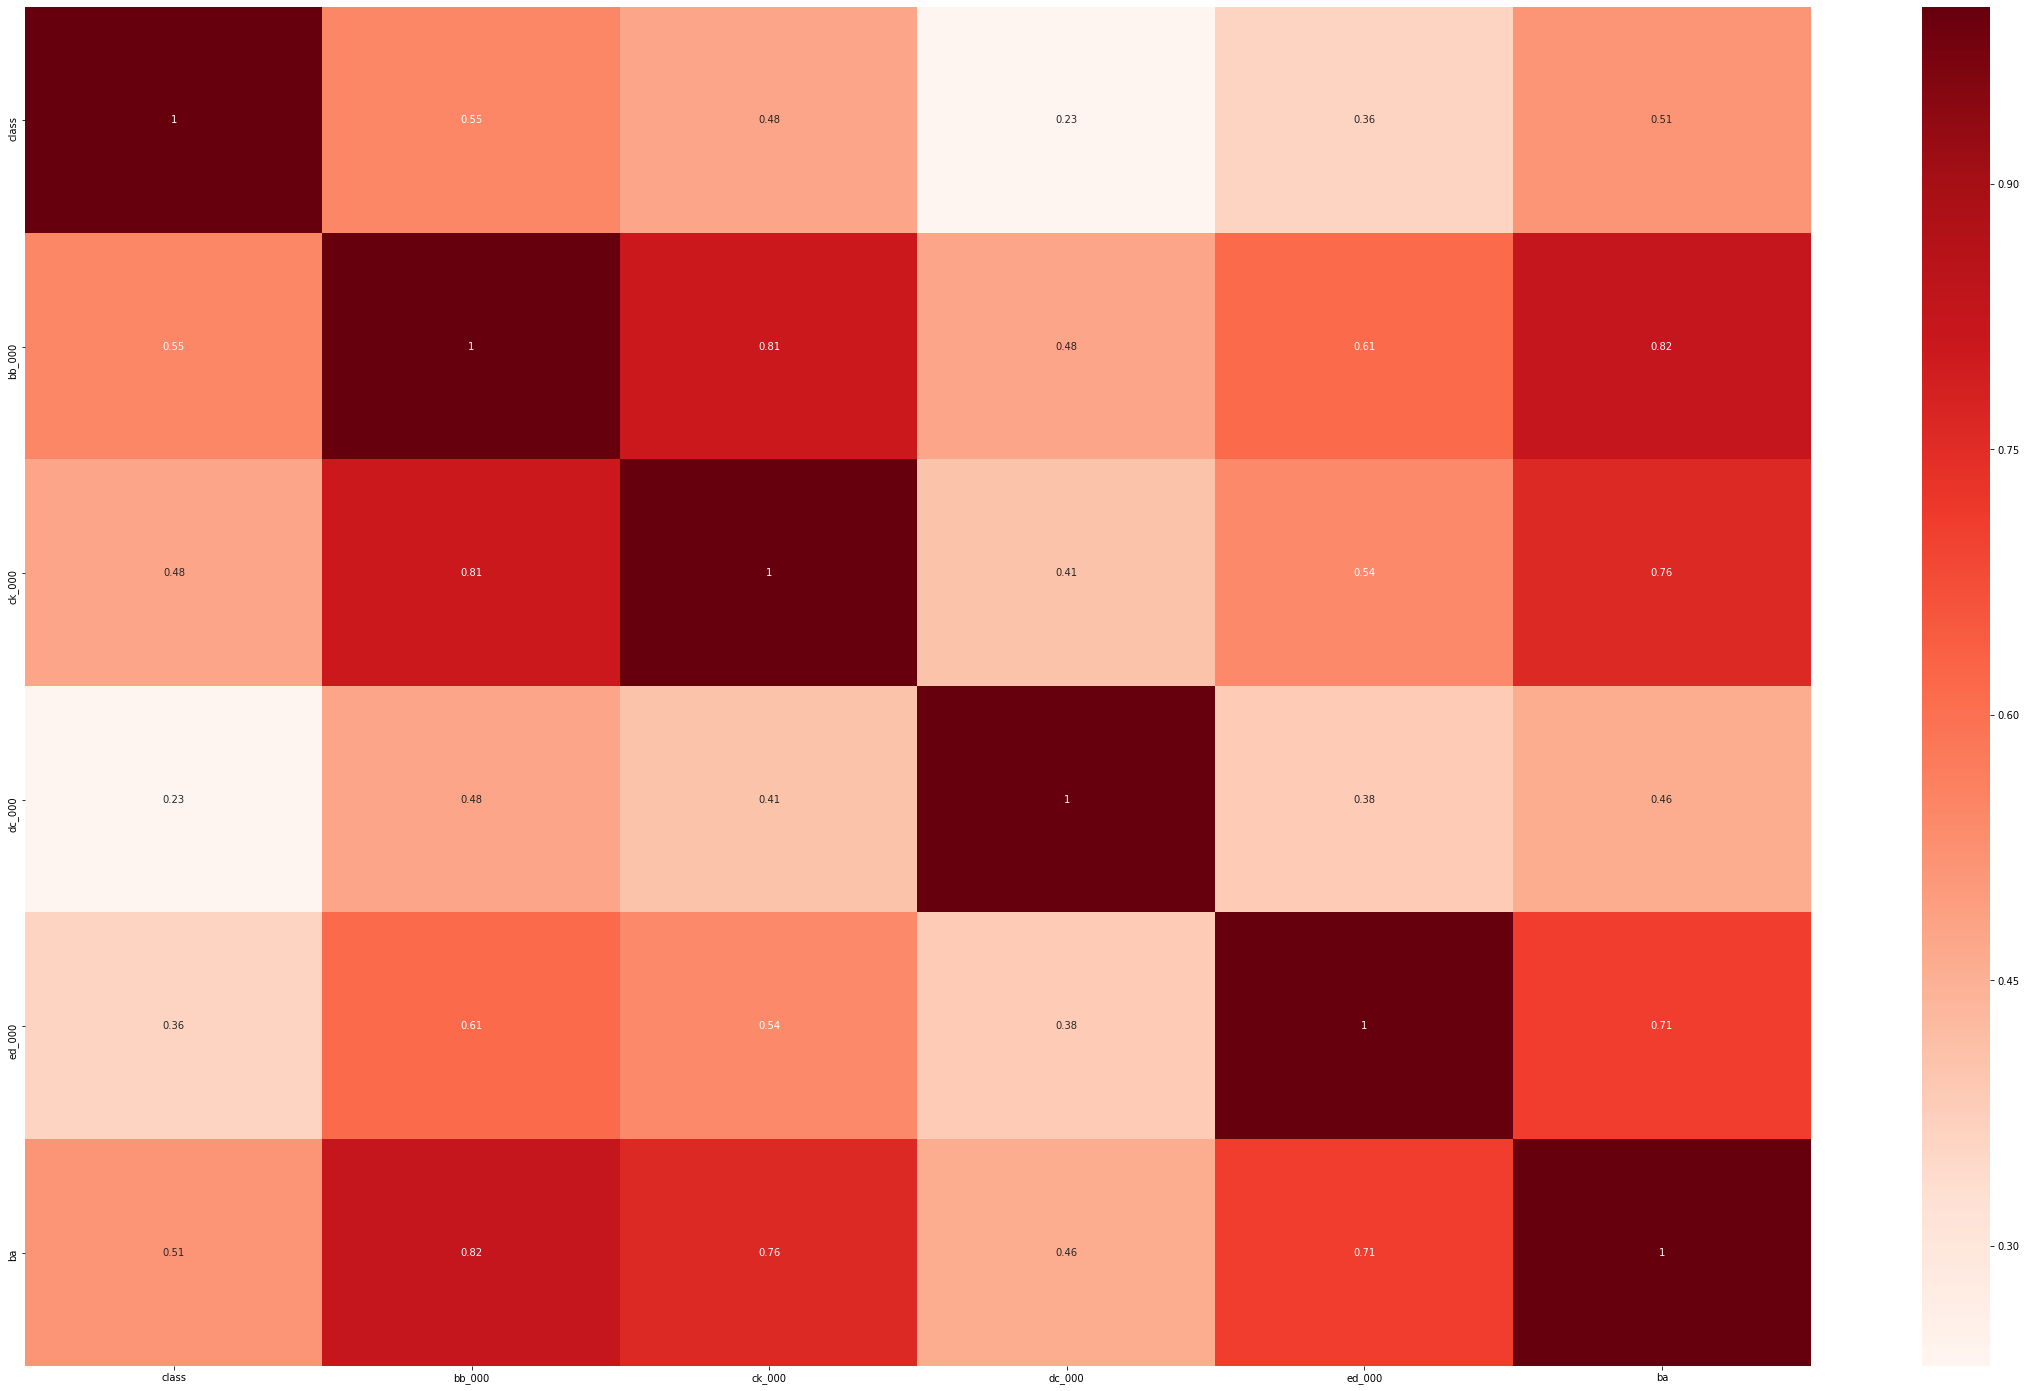

In [20]:
if (RunCorrelationAnalysis == True):
    #Using Pearson Correlation
    plt.figure(figsize=(40,25))
    cor2 = train.corr()
    sns.heatmap(cor2, annot=True, cmap=plt.cm.Reds)
    plt.show()

In [21]:
if (Upsampling == True):
    print("Upsampling On")

    train_Labels = train["class"]
    columnsNames = list(train.columns.values)

    # Oversampling minority class points, here minority class points are 1s
    if (UpsamplingAproach == "ADASYN"):
        print("ADASYN")
        ada = ADASYN(sampling_strategy = _sampling_strategy)
        train_balanced, train_3_3_balanced_Labels = ada.fit_sample(train, train_Labels)
    if(UpsamplingAproach == "SMOTE"):
        print("SMOTE")
        sm = SMOTE(sampling_strategy = _sampling_strategy)
        train_balanced, train_3_3_balanced_Labels = sm.fit_sample(train, train_Labels)

    train = pd.DataFrame(train_balanced, columns=columnsNames)

train["class"].value_counts()

Upsampling On
ADASYN


0.0    55968
1.0    44838
Name: class, dtype: int64

### Random Forest, SVM, Bagging, GridSearch

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, make_scorer
import scikitplot as skplt
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import BaggingClassifier

In [23]:
train_4model = train.copy()
pred_4model = test.copy()
pred_4model['class'] = ""

X = train_4model.drop('class', axis=1) 
y = train_4model['class']

X_pred = pred_4model.drop('class', axis=1)
#y_pred = test_4model['class']

print (train_4model.shape)
#print (test_4model.shape)

(100806, 6)


In [24]:
# Definition of the models

cost_score = make_scorer((getCost),greater_is_better = False)


if (GridSearch == True):
    
    if (ModelToUse == "SVM"):
        print("GridSearch SVM")
        model_SVM = GridSearchCV(svm.SVC(), param_grid= ParamGrid_SVM, scoring= cost_score, verbose=_verbose, cv=_cv)
        
        model_bagging = model_SVM
        
    if (ModelToUse == "RF"):
        print("GridSearch RF")
        rf = RandomForestClassifier()
        model_RF = GridSearchCV(rf, param_grid= ParamGrid_RF, scoring= cost_score, verbose=_verbose, cv=_cv)
        
        model_bagging = model_RF
else:
    
    if (ModelToUse == "RF"):
        print("Random Forest")

        model_RF = RandomForestClassifier(max_depth=_max_depth,n_estimators=_n_estimators, \
                                                bootstrap=_bootstrap, class_weight=_class_weight, \
                                                random_state=_SEED, n_jobs=_n_jobs)
        model_bagging = model_RF

    if (ModelToUse == "SVM"):
        print("SVM")
        #model_SVM = svm.SVC(gamma=1)
        model_SVM = svm.SVC(C=_C, kernel=_kernel, degree=_degree, gamma=_gamma, coef0=_coef0, \
                            shrinking=_shrinking, probability=_probability, tol=_tol, cache_size=_cache_size, \
                            class_weight=None, verbose=False, max_iter=-1, \
                            decision_function_shape=_decision_function_shape, random_state=_random_state)

        model_bagging = model_SVM

if (Bagging == True):
    print("Bagging On")
    
    model_bagging_rf = BaggingClassifier(model_bagging, n_estimators=_n_estimators, \
                                         max_samples=_max_samples, max_features=_max_features, \
                                         bootstrap=_bootstrap, bootstrap_features=_bootstrap_features, \
                                         oob_score=_oob_score, warm_start=_warm_start, n_jobs=_n_jobs, \
                                         random_state=_random_state, verbose=_verbose)

Random Forest
Bagging On


In [25]:
if (EnableSplitting == True):
    print("Train/Test splitting On")
    # Separating our data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=_test_size, stratify=y, random_state=_SEED)


if (UseExistingModel == False):
    if (Bagging == True):

        if (EnableSplitting == True):
            model_final = model_bagging_rf.fit(X_train, y_train)
            print(model_bagging_rf.score(X_test, y_test))

        else:
            model_final = model_bagging_rf.fit(X, y)

    else:    # Random Forest and SVM
        if (ModelToUse == "RF"):
            if (EnableSplitting == True):
                model_final = model_RF.fit(X_train, y_train)
                print(model_RF.score(X_test, y_test))
            else:
                model_final = model_RF.fit(X, y)
        if (ModelToUse == "SVM"):
            if (EnableSplitting == True):
                model_final = model_SVM.fit(X_train, y_train)
                print(model_SVM.score(X_test, y_test))
            else:
                model_final = model_SVM.fit(X, y)
else:
    print('Using model: ' + ModelName)
    model_final = load(ModelName)
    print(model_final.score(X_test, y_test))

Train/Test splitting On


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.9408788810633866


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


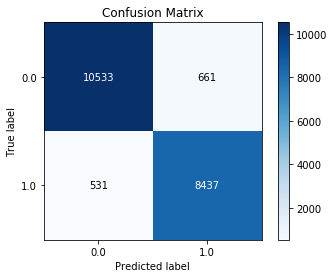

In [26]:
if(EnableSplitting == True):
    # Confusion Matrix
    y_pred = model_final.predict(X_test)
    y_pred_proba = model_final.predict_proba(X_test)
    # the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # visualizing the matrix
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False)
    plt.show()

In [27]:
print (getCost(y_test, y_pred))

1924600


### Prediction
#### Evaluating Test dataset and generating "prediction_results.csv"

In [29]:
y_pred = model_final.predict(X_pred)
res = pd.DataFrame(y_pred)
res.columns = ["Predicted"]
res.index.name = "Id"

if (FavorTrueClass == True):
    print("FavorTrueClass correction On")
    
    y_pred_proba = model_final.predict_proba(X_pred)
    res_p = pd.DataFrame(y_pred_proba)
    res2 = res.copy()
    res2['Predicted'] = res_p.apply(lambda x: FavorTrues(x[1]), axis=1)
    res2.index = X_pred.index + 1 
    res2.index.name = "Id"
    print(res2['Predicted'].value_counts())

res.index = X_pred.index + 1
res.index.name = "Id"
print(res['Predicted'].value_counts())

if (FavorTrueClass == True):
    res = res2

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.0    17563
1.0     1437
Name: Predicted, dtype: int64


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


In [30]:
from joblib import dump, load

res.sort_index(inplace=True)

if (FavorTrueClass == False):
    res['Predicted'].replace(to_replace = 1, value = "true", inplace = True)
    res['Predicted'].replace(to_replace = 0, value = "false", inplace = True)

if (SaveToFile == True):
    print("SaveToFile On")
    print("")
    res.to_csv(FileName)

    'Saving Model'
    #dump(model_final, modelFileName) 
    
print(res)

SaveToFile On

      Predicted
Id             
1         false
2         false
3         false
4         false
5         false
6         false
7         false
8         false
9         false
10         true
11        false
12        false
13        false
14        false
15        false
16        false
17        false
18        false
19        false
20        false
21         true
22        false
23        false
24        false
25        false
26        false
27        false
28        false
29        false
30        false
...         ...
18971     false
18972     false
18973     false
18974      true
18975     false
18976     false
18977     false
18978     false
18979     false
18980     false
18981     false
18982     false
18983     false
18984     false
18985     false
18986     false
18987     false
18988     false
18989     false
18990     false
18991     false
18992      true
18993     false
18994     false
18995     false
18996     false
18997     false
18998     false
18999    

In [31]:
#Beep()